In [258]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
from mplsoccer import Pitch
import json

client = MongoClient()
db = client['football_data']

In [215]:
home_team = 'Barcelona'
away_team = 'Real Madrid'

match = pd.DataFrame(list(db.matches.find({'home_team' : home_team, 'away_team' : away_team}))).iloc[0]
match_id = int(match['match_id'])

events = pd.DataFrame(list(db.events.find({'match_id' : match_id})))
lineups = pd.DataFrame(list(db.lineups.find({'match_id' : match_id})))

In [ ]:
import pandas as pd

home_team = match['home_team']
away_team = match['away_team']

# Filtry
home_events = events[events['team'] == home_team]
away_events = events[events['team'] == away_team]

# --- Funkcje pomocnicze ---
def count_shots(df):
    return len(df[df['type'] == 'Shot'])
home_shots = count_shots(home_events)
away_shots = count_shots(away_events)

def count_shots_on_target(df):
    return len(df[(df['type'] == 'Shot') & (df['shot_outcome'].isin(['Goal', 'Saved']))])
home_on_target = count_shots_on_target(home_events)
away_on_target = count_shots_on_target(away_events)

def sum_xg(df):
    return round(df[df['type'] == 'Shot']['shot_statsbomb_xg'].sum(), 2)
home_xg = sum_xg(home_events)
away_xg = sum_xg(away_events)

def count_passes(df):
    return df[df['type'] == 'Pass']
home_passes = count_passes(home_events)
away_passes = count_passes(away_events)

def count_accurate_passes(df):
    passes = count_passes(df)
    return len(passes[passes['pass_outcome'].isnull()])  # nan = celne

def pass_accuracy_pct(df):
    passes = count_passes(df)
    total = len(passes)
    accurate = count_accurate_passes(df)
    return f"{(accurate / total) * 100:.1f}%" if total > 0 else "0.0%"

def count_corners(df):
    return len(df[df['type'] == 'Corner'])

def count_penalties(df):
    shots = df[df['type'] == 'Shot']
    if 'shot' not in shots.columns:
        return 0
    return shots['shot'].apply(lambda s: isinstance(s, dict) and s.get('penalty') == True).sum()


def count_cards(lineups_data, team, card_type):
    return sum(
        1 for player in lineups_data.get(team, [])
        for card in player.get("cards", [])
        if card.get("card_type") == card_type
    )

def count_interceptions(df):
    return len(df[df['type'] == 'Interception'])

def count_tackles_won(df):
    duels = df[df['type'] == 'Duel']
    if 'duel' not in duels.columns:
        return 0
    return duels['duel'].apply(lambda d: (
        isinstance(d, dict) and
        d.get('type', {}).get('name') == 'Tackle' and
        d.get('outcome', {}).get('name') == 'Won'
    )).sum()


# --- Statystyki ---
statystyki = {
    'Gole': [match['home_score'], match['away_score']],
    'Strza≈Çy': [home_shots, away_shots],
    'Strza≈Çy celne': [home_on_target, away_on_target],
    'xG': [home_xg, away_xg],
    'Celne podania': [count_accurate_passes(home_events), count_accurate_passes(away_events)],
    '% celnych poda≈Ñ': [pass_accuracy_pct(home_events), pass_accuracy_pct(away_events)],
    'Rzuty ro≈ºne': [count_corners(home_events), count_corners(away_events)],
    'Rzuty karne': [count_penalties(home_events), count_penalties(away_events)],
    '≈ª√≥≈Çte kartki': [count_cards(lineups_data, home_team, 'Yellow Card'),
                     count_cards(lineups_data, away_team, 'Yellow Card')],
    'Czerwone kartki': [count_cards(lineups_data, home_team, 'Red Card'),
                        count_cards(lineups_data, away_team, 'Red Card')],
    'Przechwyty': [count_interceptions(home_events), count_interceptions(away_events)],
    'Odbiory': [count_tackles_won(home_events), count_tackles_won(away_events)],
}

# --- Tabela ko≈Ñcowa ---
stats_df = pd.DataFrame.from_dict(statystyki, orient='index', columns=[home_team, away_team])
stats_df.index.name = 'Statystyka'

# Wy≈õwietlenie
stats_df


Barcelona Real Madrid
Statystyka                           
Gole                    1           2
Strza≈Çy                14          15
Strza≈Çy celne           3           6
xG                   0.73        1.32
Celne podania         645         279
% celnych poda≈Ñ     90.6%       79.7%
Rzuty ro≈ºne             0           0
Rzuty karne             0           0
≈ª√≥≈Çte kartki            3           3
Czerwone kartki         0           0
Przechwyty              5          12
Odbiory                 0           0

In [267]:
print(events['pass_outcome'].unique())


[nan 'Incomplete' 'Pass Offside' 'Out' 'Unknown']


In [238]:
print(f"{match['home_team']} vs {match['away_team']}")
print(f"Wynik: {match['home_score']} - {match['away_score']}")
print(f"Data: {match['match_date']}")
print(f"Kolejka: {match.get('match_week')}")
print(f"Stadion: {match.get('stadium')}")

referee = match.get('referee')
print(f"Sƒôdzia: {'brak danych' if pd.isna(referee) else referee}")


Barcelona vs Real Madrid
Wynik: 1 - 2
Data: 2016-04-02
Kolejka: 31
Stadion: Spotify Camp Nou
Sƒôdzia: brak danych


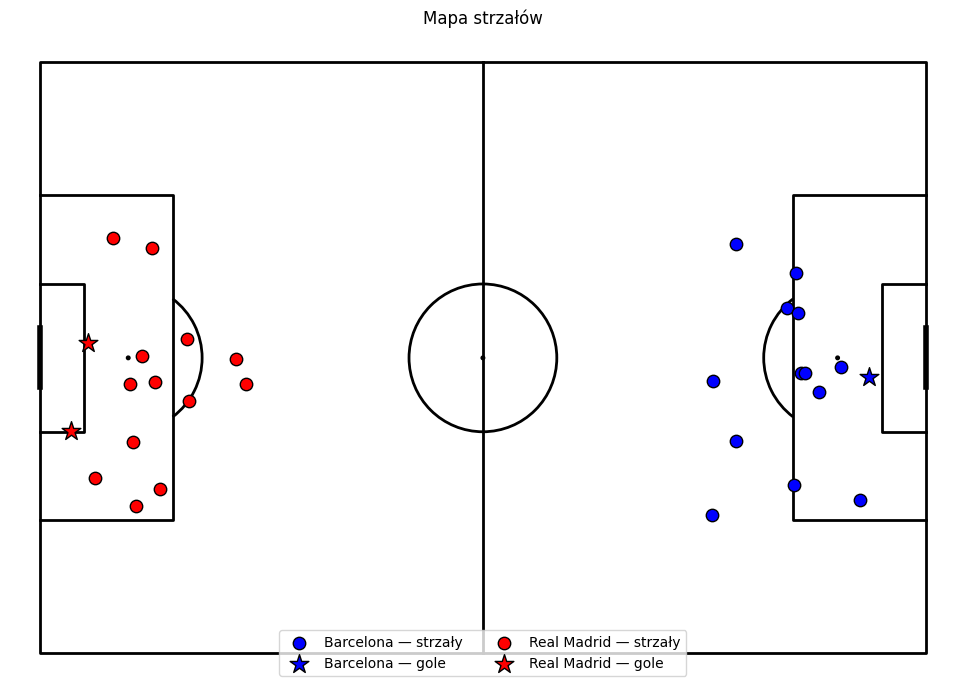

In [251]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt

# --- Przygotowanie danych ---
shots = events[(events['type'] == 'Shot') & (events['location'])].copy()
shots['x'] = shots['location'].apply(lambda loc: loc[0])
shots['y'] = shots['location'].apply(lambda loc: loc[1])
shots['team_name'] = shots['team']  # zak≈Çadamy, ≈ºe 'team' to string

# Odbicie po≈Çowy go≈õci
shots.loc[shots['team_name'] == away_team, 'x'] = 120 - shots['x']
shots.loc[shots['team_name'] == away_team, 'y'] = 80 - shots['y']

# --- Podzia≈Ç danych ---
home_shots = shots[shots['team_name'] == home_team]
away_shots = shots[shots['team_name'] == away_team]

home_goals = home_shots[home_shots['shot_outcome'] == 'Goal']
home_others = home_shots[home_shots['shot_outcome'] != 'Goal']

away_goals = away_shots[away_shots['shot_outcome'] == 'Goal']
away_others = away_shots[away_shots['shot_outcome'] != 'Goal']

#Rysowanie
pitch = Pitch(pitch_type='statsbomb', pitch_color='white', line_color='black')
fig, ax = pitch.draw(figsize=(10, 7))

# Strza≈Çy gospodarzy
pitch.scatter(
    home_others['x'], home_others['y'],
    ax=ax, c='blue', edgecolors='black', s=80, label=f'{home_team} ‚Äî strza≈Çy'
)
# Gole gospodarzy
pitch.scatter(
    home_goals['x'], home_goals['y'],
    ax=ax, c='blue', edgecolors='black', s=200, marker='*', label=f'{home_team} ‚Äî gole'
)

# Strza≈Çy go≈õci
pitch.scatter(
    away_others['x'], away_others['y'],
    ax=ax, c='red', edgecolors='black', s=80, label=f'{away_team} ‚Äî strza≈Çy'
)
# Gole go≈õci
pitch.scatter(
    away_goals['x'], away_goals['y'],
    ax=ax, c='red', edgecolors='black', s=200, marker='*', label=f'{away_team} ‚Äî gole'
)

plt.title('Mapa strza≈Ç√≥w')
plt.legend(loc='lower center', ncol=2)
plt.tight_layout()
plt.show()


In [240]:
summary = {
    'home_team': match['home_team'],
    'away_team': match['away_team'],
    'Strza≈Çy': [
        len(events[(events['type'] == 'Shot') & (events['team'] == match['home_team'])]),
        len(events[(events['type'] == 'Shot') & (events['team'] == match['away_team'])])
    ],
    'Gole': [
        match['home_score'],
        match['away_score']
    ],
    'xG': [
        events[(events['type'] == 'Shot') & (events['team'] == match['home_team'])]['shot_statsbomb_xg'].sum(),
        events[(events['type'] == 'Shot') & (events['team'] == match['away_team'])]['shot_statsbomb_xg'].sum()
    ]
}

pd.DataFrame(summary, index=['Home', 'Away']).T


Home         Away
home_team    Barcelona    Barcelona
away_team  Real Madrid  Real Madrid
Strza≈Çy             14           15
Gole                 1            2
xG             0.72507     1.320553

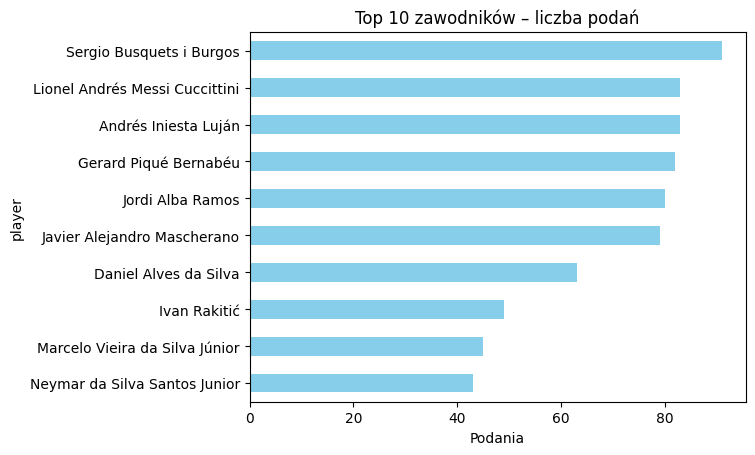

In [221]:
top_passes = events[events['type'] == 'Pass'].groupby('player').size().sort_values(ascending=False).head(10)
top_passes.plot(kind='barh', title='Top 10 zawodnik√≥w ‚Äì liczba poda≈Ñ', color='skyblue')
plt.xlabel('Podania')
plt.gca().invert_yaxis()
plt.show()


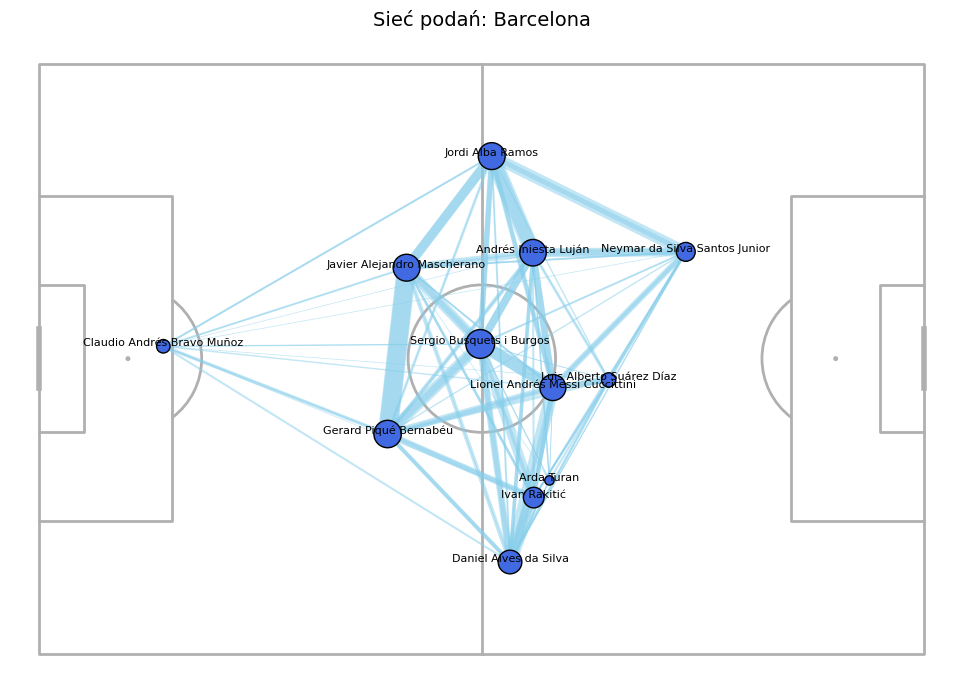

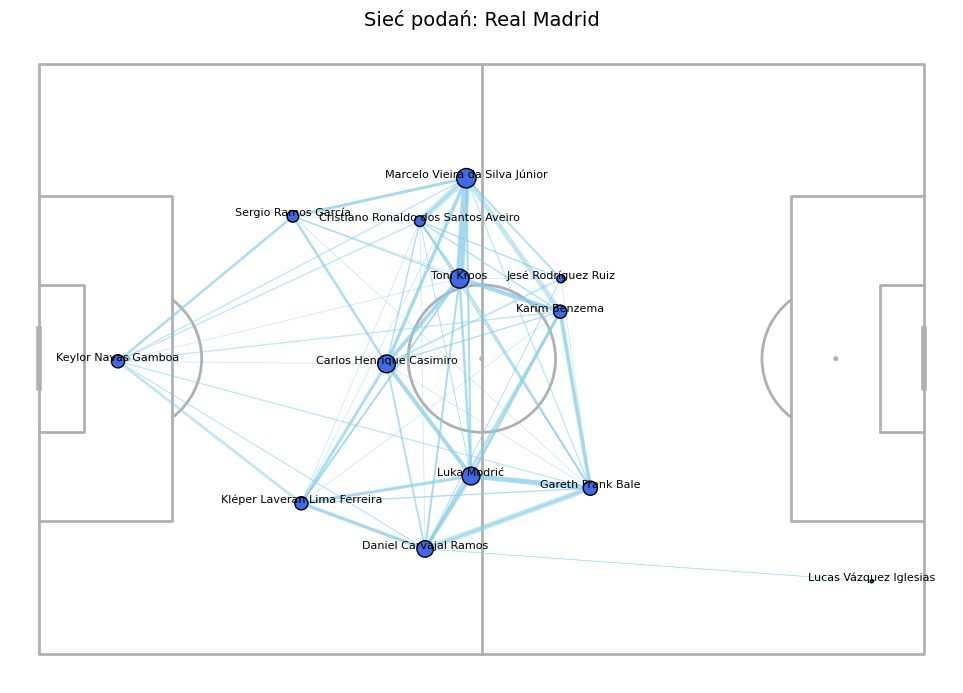

In [223]:
# ===== Sieƒá poda≈Ñ dla ka≈ºdej z dru≈ºyn =====


# Filtrowanie uko≈Ñczonych poda≈Ñ z nazwiskami i lokalizacjami
passes = events[
    (events['type'] == 'Pass') &
    (events['pass_outcome'].isnull()) &
    (events['location'].notnull()) &
    (events['pass_end_location'].notnull()) &
    (events['player'].notnull()) &
    (events['team'].notnull())
]

teams = passes['team'].unique()
passes_by_team = {team: passes[passes['team'] == team] for team in teams}

def create_pass_network(passes, team_name):
    # ≈örednia pozycja ka≈ºdego gracza
    avg_locs = passes.groupby('player').agg(
        x=('location', lambda locs: np.mean([loc[0] for loc in locs])),
        y=('location', lambda locs: np.mean([loc[1] for loc in locs])),
        count=('player', 'count')
    ).reset_index()

    # Czƒôstotliwo≈õƒá poda≈Ñ miƒôdzy zawodnikami
    combinations = passes.groupby(['player', 'pass_recipient']).size().reset_index(name='count')
    combinations = combinations[combinations['pass_recipient'].notnull()]

    loc_dict = avg_locs.set_index('player')[['x', 'y']].to_dict('index')

    # Rysowanie boiska
    pitch = Pitch(pitch_type='statsbomb', line_zorder=2)
    fig, ax = pitch.draw(figsize=(10, 7))
    plt.title(f'Sieƒá poda≈Ñ: {team_name}', fontsize=14)

    # Linie poda≈Ñ
    for _, row in combinations.iterrows():
        p1, p2 = row['player'], row['pass_recipient']
        if p1 in loc_dict and p2 in loc_dict:
            x1, y1 = loc_dict[p1]['x'], loc_dict[p1]['y']
            x2, y2 = loc_dict[p2]['x'], loc_dict[p2]['y']
            pitch.lines(x1, y1, x2, y2, ax=ax, lw=row['count'] / 2, color='skyblue', alpha=0.5)

    # Pozycje graczy
    pitch.scatter(avg_locs['x'], avg_locs['y'], s=avg_locs['count']*5, ax=ax,
                  color='royalblue', edgecolors='black', zorder=3)

    for _, row in avg_locs.iterrows():
        pitch.annotate(row['player'], (row['x'], row['y']), ax=ax, fontsize=8, ha='center')

    return fig, ax

# Tworzenie wykres√≥w
for team, team_passes in passes_by_team.items():
    create_pass_network(team_passes, team)
    plt.show()


In [225]:
import pandas as pd
import json

# --- Konwersja kolumny 'cards' z tekstu do listy s≈Çownik√≥w ---
def parse_cards(card_str):
    if isinstance(card_str, str) and card_str.startswith("["):
        try:
            return json.loads(card_str.replace("'", '"'))
        except json.JSONDecodeError:
            return []
    return card_str

lineups['cards'] = lineups['cards'].apply(parse_cards)

# --- Zamiana DataFrame lineups na s≈Çownik dru≈ºyn ---
lineups_data = {
    team: group.to_dict(orient="records")
    for team, group in lineups.groupby("team")
}

# --- Filtrujemy zdarzenia z meczu ---
match_events = events.copy()
timeline = []

# --- Gole i samob√≥je ---
normal_goals = match_events[(match_events['type'] == 'Shot') & (match_events['shot_outcome'] == 'Goal')]
own_goals = match_events[match_events['type'] == 'Own Goal For']
goals = pd.concat([normal_goals, own_goals], ignore_index=True)
goals['minute'] = goals['minute'] + 1

for _, row in goals.iterrows():
    timeline.append({
        'minute': row['minute'],
        'second': row.get('second', 0),
        'team': row.get('team', None),
        'player': row.get('player', None),
        'type': '‚öΩ Gol' if row['type'] == 'Shot' else '‚ùå Samob√≥j',
    })

# --- Kartki z lineups_data ---
for team_name, players in lineups_data.items():
    for player in players:
        for card in player.get("cards", []):
            card_type = card.get("card_type")
            time_str = card.get("time", "0:0")
            try:
                minute, second = map(int, time_str.split(":"))
            except:
                minute, second = 0, 0

            symbol = {
                "Yellow Card": "üü°",
                "Second Yellow": "üü°üü°",
                "Red Card": "üî¥"
            }.get(card_type, "‚ùó")

            timeline.append({
                'minute': minute + 1,
                'second': second,
                'team': team_name,
                'player': player.get("player_name", "Brak danych"),
                'type': f'{symbol} {card_type}'
            })

# --- Zmiany ---
subs = match_events[match_events['type'] == 'Substitution'].copy()
subs['minute'] = subs['minute'] + 1

for _, row in subs.iterrows():
    timeline.append({
        'minute': row['minute'],
        'second': row.get('second', 0),
        'team': row.get('team', None),
        'player': f"{row.get('player')} ‚û°Ô∏è {row.get('substitution_replacement')}",
        'type': 'üîÅ Zmiana'
    })

# --- Koniec po≈Ç√≥w i doliczony czas ---
half_ends = (
    match_events[match_events['type'] == 'Half End']
    .sort_values(['period', 'minute', 'second'])
    .drop_duplicates(subset='period', keep='last')  # tylko ostatni wpis dla ka≈ºdej po≈Çowy
)

for _, row in half_ends.iterrows():
    period = row.get("period", None)
    minute = row.get("minute", 0)
    second = row.get("second", 0)

    if period == 1:
        if minute > 45:
            timeline.append({
                'minute': 45,
                'second': 0,
                'team': '',
                'player': '',
                'type': f'‚è±Ô∏è Doliczony czas 1. po≈Çowy: +{minute - 45} min'
            })
        timeline.append({
            'minute': minute,
            'second': second,
            'team': '',
            'player': '',
            'type': 'üîö Koniec 1. po≈Çowy'
        })

    elif period == 2:
        if minute > 90:
            timeline.append({
                'minute': 90,
                'second': 0,
                'team': '',
                'player': '',
                'type': f'‚è±Ô∏è Doliczony czas 2. po≈Çowy: +{minute - 90} min'
            })
        timeline.append({
            'minute': minute,
            'second': second,
            'team': '',
            'player': '',
            'type': 'üîö Koniec meczu'
        })


# --- Tworzymy DataFrame i sortujemy po czasie ---
timeline_df = pd.DataFrame(timeline)
timeline_df = timeline_df.sort_values(by=['minute', 'second']).reset_index(drop=True)

# --- Formatowanie i wy≈õwietlenie ---
timeline_df['czas'] = timeline_df['minute'].astype(str).str.zfill(2) + "'"  # np. 67'
timeline_df = timeline_df[['czas', 'team', 'player', 'type']]
timeline_df.columns = ['‚è± Minuta', 'Dru≈ºyna', 'Zawodnik / Akcja', 'Zdarzenie']

display(timeline_df)


‚è± Minuta      Dru≈ºyna                             Zawodnik / Akcja  \
0       10'  Real Madrid                          Sergio Ramos Garc√≠a   
1       18'  Real Madrid                        Daniel Carvajal Ramos   
2       27'    Barcelona                     Luis Alberto Su√°rez D√≠az   
3       29'    Barcelona                  Javier Alejandro Mascherano   
4       45'                                                             
5       46'                                                             
6       56'    Barcelona                        Gerard Piqu√© Bernab√©u   
7       58'    Barcelona                                 Ivan Rakitiƒá   
8       62'  Real Madrid                                Karim Benzema   
9       74'    Barcelona                   Ivan Rakitiƒá ‚û°Ô∏è Arda Turan   
10      78'  Real Madrid         Karim Benzema ‚û°Ô∏è Jes√© Rodr√≠guez Ruiz   
11      81'  Real Madrid          Cristiano Ronaldo dos Santos Aveiro   
12      83'  Real Madrid                          Sergio Ramos Garc√≠a   
13      85'  Real Madrid          Cristiano Ronaldo dos Santos Aveiro   
14      90'                                                             
15      91'  Real Madrid  Gareth Frank Bale ‚û°Ô∏è Lucas V√°zquez Iglesias   
16      92'                                                             

                              Zdarzenie  
0                         üü° Yellow Card  
1                         üü° Yellow Card  
2                         üü° Yellow Card  
3                         üü° Yellow Card  
4   ‚è±Ô∏è Doliczony czas 1. po≈Çowy: +1 min  
5                    üîö Koniec 1. po≈Çowy  
6                                 ‚öΩ Gol  
7                         üü° Yellow Card  
8                                 ‚öΩ Gol  
9                              üîÅ Zmiana  
10                             üîÅ Zmiana  
11                        üü° Yellow Card  
12                     üü°üü° Second Yellow  
13                                ‚öΩ Gol  
14  ‚è±Ô∏è Doliczony czas 2. po≈Çowy: +2 min  
15                             üîÅ Zmiana  
16                       üîö Koniec meczu

In [ ]:
starting_xi = events[events['type'] == 'Starting XI']
starting_players = []

for _, row in starting_xi.iterrows():
    team = row['team']
    for player in row['tactics']['lineup']:
        starting_players.append({
            'team': team,
            'player_name': player['player']['name'],
            'jersey_number': player['jersey_number'],
            'position': player['position']['name']
        })

starting_df = pd.DataFrame(starting_players)
display(starting_df)


team                          player_name  jersey_number  \
0     Barcelona           Claudio Andr√©s Bravo Mu√±oz             13   
1     Barcelona                Daniel Alves da Silva              6   
2     Barcelona                Gerard Piqu√© Bernab√©u              3   
3     Barcelona          Javier Alejandro Mascherano             14   
4     Barcelona                     Jordi Alba Ramos             18   
5     Barcelona             Sergio Busquets i Burgos              5   
6     Barcelona                         Ivan Rakitiƒá              4   
7     Barcelona                 Andr√©s Iniesta Luj√°n              8   
8     Barcelona             Luis Alberto Su√°rez D√≠az              9   
9     Barcelona        Neymar da Silva Santos Junior             11   
10    Barcelona       Lionel Andr√©s Messi Cuccittini             10   
11  Real Madrid                  Keylor Navas Gamboa              1   
12  Real Madrid                Daniel Carvajal Ramos             15   
13  Real Madrid         Kl√©per Laveran Lima Ferreira              3   
14  Real Madrid                  Sergio Ramos Garc√≠a              4   
15  Real Madrid       Marcelo Vieira da Silva J√∫nior             12   
16  Real Madrid             Carlos Henrique Casimiro             14   
17  Real Madrid                          Luka Modriƒá             19   
18  Real Madrid                           Toni Kroos              8   
19  Real Madrid                    Gareth Frank Bale             11   
20  Real Madrid  Cristiano Ronaldo dos Santos Aveiro              7   
21  Real Madrid                        Karim Benzema              9   

                     position  
0                  Goalkeeper  
1                  Right Back  
2           Right Center Back  
3            Left Center Back  
4                   Left Back  
5   Center Defensive Midfield  
6       Right Center Midfield  
7        Left Center Midfield  
8                  Right Wing  
9                   Left Wing  
10             Center Forward  
11                 Goalkeeper  
12                 Right Back  
13          Right Center Back  
14           Left Center Back  
15                  Left Back  
16  Center Defensive Midfield  
17      Right Center Midfield  
18       Left Center Midfield  
19                 Right Wing  
20                  Left Wing  
21             Center Forward

In [232]:
# Gole
goals = events[(events['type'] == 'Shot') & (events['shot_outcome'] == 'Goal') | (events['type'] == 'Own Goal For')]

goals_df = goals[['minute', 'timestamp', 'team', 'player']].copy()
goals_df['minute'] = goals_df['minute'] + 1
goals_df



minute     timestamp         team                               player
3625      56  00:10:45.095    Barcelona                Gerard Piqu√© Bernab√©u
3626      62  00:16:56.547  Real Madrid                        Karim Benzema
3634      85  00:39:36.249  Real Madrid  Cristiano Ronaldo dos Santos Aveiro